# Logistic Regression
In this example I use logistic regression to predict customer churn with Logistic Regression.
We use data from Telco hosted on IBM with data on custome tenure, age, income, education and others to train and test a logistic regression model. 

Let's start by installing and importing useful packages

In [1]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])
await piplite.install(['scipy'])

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

## Data collection
As anticipated, we use a synthetic Telco database concerning churn data. Each line of our database will represent a customer, where the churn outcome has been already dummied to where `1.0` indicates a client that dropped the service an `0.0` indicates a client that ended up staying with Telco.

In [4]:
path= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv"
await download(path, "ChurnData.csv")
path="ChurnData.csv"

We can check the data

In [5]:
churn_df = pd.read_csv(path)
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


While our churn variable has already been prepared with a dummy variable, we still need to pre-process our date. 

We need to, first, select the data that will actually help us in our job, as such we only select the following columns: `tenure`, `age`, `address`, `income`, `ed`, `employ`, `equip`, `callcard`, `wireless`, `churn`.

As much as `1.0` and `0.0` are already numeric variables, we need to transform them into integers.

In [9]:
#Data selection
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


Let's transform our data into a numpy array and normalize them using the `StandardScaler` function. We can also `churn` as our target variable.

In [10]:
#Array preparation
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
y = np.asarray(churn_df['churn'])

#Normalization
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

We can now split our dataset into train and test sets.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1234)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 7) (160,)
Test set: (40, 7) (40,)


## Setting up the model
We can now build the LogisticRegression item, we will use a very strong regularization parameter to solve overfitting. We will also use the `libilinear` solver as our job is limited to a one-versus-rest schema.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#Let's create a LogisticRegression item and fit it on our train set
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

We can now use it on our test set to make predictions.

In [13]:
#We can predict the outcome of our test set
yhat = LR.predict(X_test)

## Evaluation
We will use both the jaccard index and confusion matrices to verify the results of our model.

In [14]:
from sklearn.metrics import jaccard_score
#Let's calculate the jaccard score index for our model
jaccard_score(y_test, yhat,pos_label=0)

0.7419354838709677

In [15]:
#We can then use this function to create a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 9  2]
 [ 6 23]]


Confusion matrix, without normalization
[[ 9  2]
 [ 6 23]]


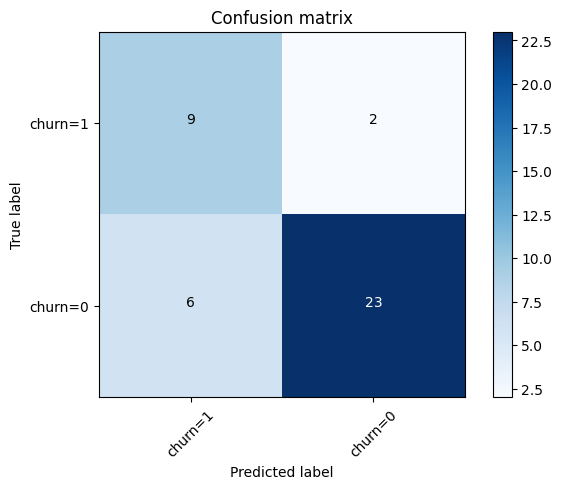

In [16]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

This confusion matrix shows us that the rate of True Positives and True Negatives is very high compared to Flase Positives and False Negatives. 

We can also check the precision, recall and F1 score of our model:

In [17]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.92      0.79      0.85        29
           1       0.60      0.82      0.69        11

    accuracy                           0.80        40
   macro avg       0.76      0.81      0.77        40
weighted avg       0.83      0.80      0.81        40



Another important method for evaluation in LogisticRegression is the log loss, the output is the probability of a customer churn being equal to 1, this way we can measure the performance of the classifier.

In [19]:
from sklearn.metrics import log_loss
#We first need to define the estimates for all classes ordered by label
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.5723178226347725